# Import modules

In [192]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark = True


# Define visualize function

In [249]:
def visualize(data):
    colors = {0: 'red', 1: 'blue', 2: 'green'}

    dfs = []

    for x, y in data:
        dfs += [pd.DataFrame({
            'x': x[:,0],
            'y': x[:,1],
            'label': y
        })]

    df = pd.concat(dfs)
    groups = df.groupby('label')
    
    fig, ax = plt.subplots()
    for k, group in groups:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=k, color=colors[k])
    plt.show()

# Dataloader for pytorch

In [254]:
def generate_dataloader(data, test_size):
    x, y = data
    x = torch.Tensor(x)
    y = torch.LongTensor(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    return lambda **kwargs: (DataLoader(list(zip(x_train, y_train)), **kwargs), DataLoader(list(zip(x_test, y_test)), **kwargs))


In [283]:
moon_train_loader, moon_test_loader = generate_dataloader(make_moons(n_samples=1280, noise=0.2), 0.3)(batch_size=64)
blob_train_loader, blob_test_loader = generate_dataloader(make_blobs(n_samples=1280, centers=3), 0.3)(batch_size=64)

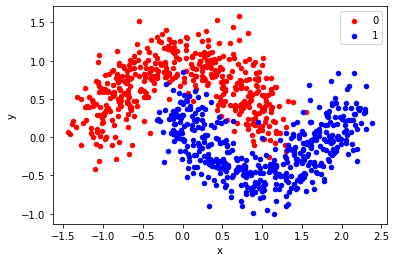

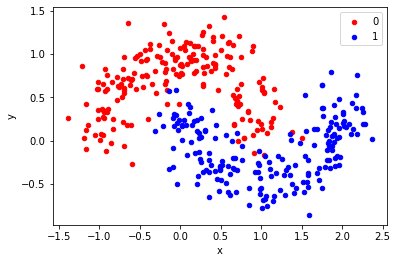

In [284]:
visualize(moon_train_loader)
visualize(moon_test_loader)

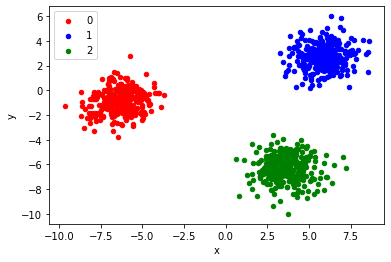

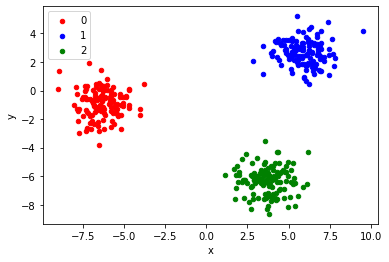

In [262]:
visualize(blob_train_loader)
visualize(blob_test_loader)

# Define Model
I used hyperbolic tangent instead of sigmoid for activation.

In [190]:
SimpleLinear = lambda out_channels: nn.Linear(2, out_channels)

SimpleMLP = lambda out_channels: nn.Sequential(
    nn.Linear(2, 2),
    nn.Tanh(),
    nn.Linear(2, 2),
    nn.Tanh(),
    nn.Linear(2, out_channels)
)

ComplexMLP = lambda out_channels: nn.Sequential(
    nn.Linear(2, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, out_channels)
)


# Helper Class(Trainer)

In [289]:
class Trainer:
    def __init__(self, model, optimizer, criterion) -> None:
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

        self.train_loss_history = []
        self.train_acc_history = []
        self.val_loss_history = []
        self.val_acc_history = []

    def train(self, max_epoch, train_loader, val_loader):
        prog_bar = tqdm(range(max_epoch), position=0, leave=True)

        for epoch in prog_bar:
            train_losses = []
            val_losses = []

            train_accs = []
            val_accs = []

            self.model.train()

            for x_train, y_train in train_loader:
                self.optimizer.zero_grad()
                y_pred = self.model(x_train)
                loss = self.criterion(y_pred, y_train)
                loss.backward()
                self.optimizer.step()

                acc = sum(y_pred.argmax(dim=1) == y_train) / y_train.size(0)

                train_losses += [loss.detach()]
                train_accs += [acc.detach()]

            self.model.eval()

            for x_val, y_val in val_loader:
                with torch.no_grad():
                    y_pred = self.model(x_val)
                    loss = self.criterion(y_pred, y_val)

                    acc = sum(y_pred.argmax(dim=1) == y_val) / y_val.size(0)
                
                val_losses += [loss.detach()]
                val_accs += [acc.detach()]
            
            epoch_train_loss = torch.stack(train_losses).mean().item()
            epoch_val_loss = torch.stack(val_losses).mean().item()

            epoch_train_acc = torch.stack(train_accs).mean().item()
            epoch_val_acc = torch.stack(val_accs).mean().item()

            self.train_loss_history += [epoch_train_loss]
            self.train_acc_history += [epoch_train_acc]
            
            self.val_loss_history += [epoch_val_loss]
            self.val_acc_history += [epoch_val_acc]

            prog_bar.set_postfix({'train_loss': epoch_train_loss, 'train_accuracy': epoch_train_acc, 'val_loss': epoch_val_loss, 'val_accuracy': epoch_val_acc, 'max_val_accuracy': max(self.val_acc_history)})

    def plot(self):
        plt.title('Loss')
        plt.plot(self.train_loss_history, label='train')
        plt.plot(self.val_loss_history, label='validation')
        plt.legend()
        plt.xlabel('Epoch')
        plt.show()

        plt.title('Accuracy')
        plt.plot(self.train_acc_history, label='train')
        plt.plot(self.val_acc_history, label='validation')
        plt.legend()
        plt.xlabel('Epoch')
        plt.show()

    def __clear_history(self):
        self.train_acc_history.clear()
        self.train_loss_history.clear()
        self.val_acc_history.clear()
        self.val_loss_history.clear()
        

# Train and evaluate on moon shape data

In [306]:
criterion = nn.CrossEntropyLoss()

OUT_CHANNELS = 2
EPOCH = 500

simple_linear = SimpleLinear(OUT_CHANNELS)
simple_linear_optimizer = torch.optim.Adam(simple_linear.parameters(), lr=0.01)

simple_mlp = SimpleMLP(OUT_CHANNELS)
simple_mlp_optimizer = torch.optim.Adam(simple_mlp.parameters(), lr=0.01)

complex_mlp = ComplexMLP(OUT_CHANNELS)
complex_mlp_optimizer = torch.optim.Adam(complex_mlp.parameters(), lr=0.01)


100%|██████████| 500/500 [00:05<00:00, 87.21it/s, train_loss=0.29, train_accuracy=0.864, val_loss=0.261, val_accuracy=0.859, max_val_accuracy=0.872] 


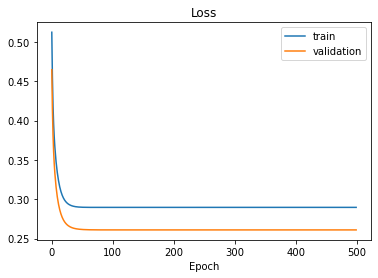

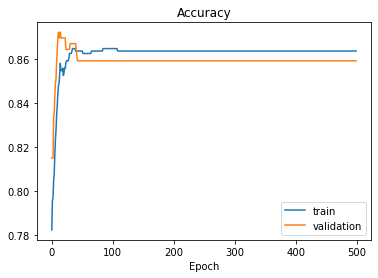

In [307]:
trainer = Trainer(simple_linear, simple_linear_optimizer, criterion)
trainer.train(EPOCH, moon_train_loader, moon_test_loader)
trainer.plot()

100%|██████████| 500/500 [00:06<00:00, 73.09it/s, train_loss=0.282, train_accuracy=0.862, val_loss=0.248, val_accuracy=0.862, max_val_accuracy=0.872]


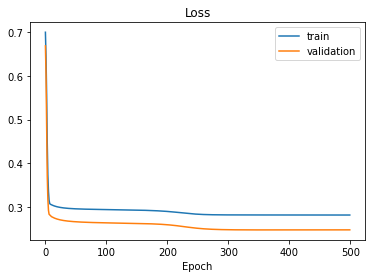

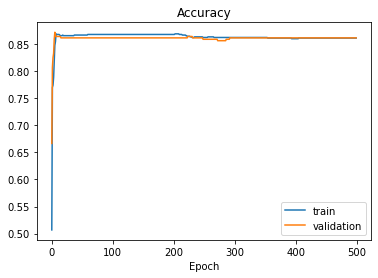

In [308]:
trainer = Trainer(simple_mlp, simple_mlp_optimizer, criterion)
trainer.train(EPOCH, moon_train_loader, moon_test_loader)
trainer.plot()

100%|██████████| 500/500 [00:07<00:00, 69.18it/s, train_loss=0.0745, train_accuracy=0.975, val_loss=0.0672, val_accuracy=0.979, max_val_accuracy=0.979]


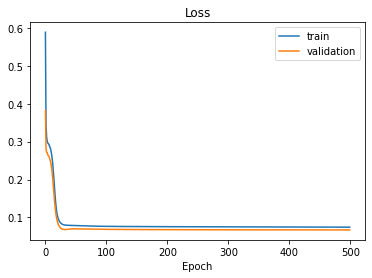

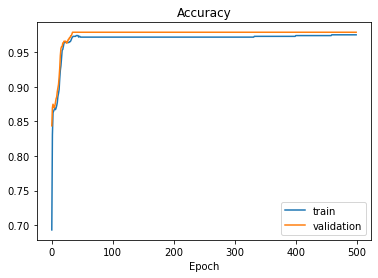

In [309]:
trainer = Trainer(complex_mlp, complex_mlp_optimizer, criterion)
trainer.train(EPOCH, moon_train_loader, moon_test_loader)
trainer.plot()

# Train and evaluate on blob shape data

In [310]:
OUT_CHANNELS = 3

simple_linear = SimpleLinear(OUT_CHANNELS)
simple_linear_optimizer = torch.optim.Adam(simple_linear.parameters(), lr=0.01)

simple_mlp = SimpleMLP(OUT_CHANNELS)
simple_mlp_optimizer = torch.optim.Adam(simple_mlp.parameters(), lr=0.01)

complex_mlp = ComplexMLP(OUT_CHANNELS)
complex_mlp_optimizer = torch.optim.Adam(complex_mlp.parameters(), lr=0.01)

100%|██████████| 500/500 [00:05<00:00, 89.07it/s, train_loss=0.00037, train_accuracy=1, val_loss=0.000566, val_accuracy=1, max_val_accuracy=1]          


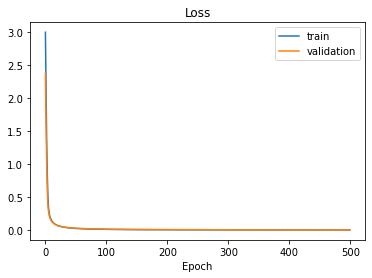

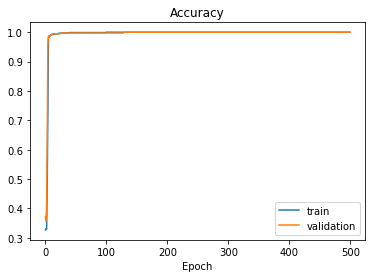

In [311]:
trainer = Trainer(simple_linear, simple_linear_optimizer, criterion)
trainer.train(EPOCH, blob_train_loader, blob_test_loader)
trainer.plot()

100%|██████████| 500/500 [00:06<00:00, 72.01it/s, train_loss=6.38e-5, train_accuracy=1, val_loss=6.47e-5, val_accuracy=1, max_val_accuracy=1]      


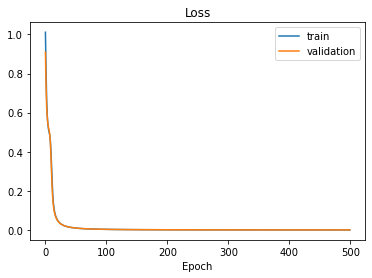

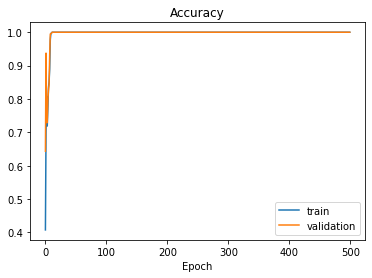

In [312]:
trainer = Trainer(simple_mlp, simple_mlp_optimizer, criterion)
trainer.train(EPOCH, blob_train_loader, blob_test_loader)
trainer.plot()

100%|██████████| 500/500 [00:07<00:00, 67.49it/s, train_loss=3.23e-6, train_accuracy=1, val_loss=0.00022, val_accuracy=1, max_val_accuracy=1]        


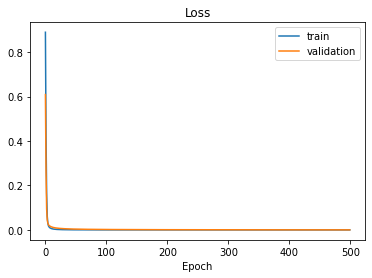

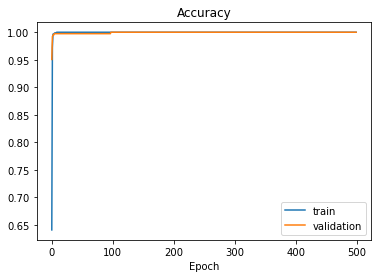

In [313]:
trainer = Trainer(complex_mlp, complex_mlp_optimizer, criterion)
trainer.train(EPOCH, blob_train_loader, blob_test_loader)
trainer.plot()